In [28]:
import numpy as np

# For plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata

import deepxde as dde
dde.backend.set_default_backend("tensorflow")
import tensorflow as tf

Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [29]:
t_max = 5

rpho = 1
mu = 1e-3

A = 10
x_min, x_max = 0, 1
y_min, y_max = 0, 1

x_min_barrier, x_max_barrier = 0.1, 0.3
y_min_barrier, y_max_barrier = 0.4, 0.6

step = 0.1
step_t = 0.1

t_points = int(t_max / step_t)
x_points = int((x_max - x_min) / step)
y_points = int((y_max - y_min) / step)

# Creation of the 2D domain (for plotting and input)
x = np.linspace(x_min, x_max, x_points)
y = np.linspace(y_min, y_max, y_points)
t = np.linspace(0, t_max, t_points)
x, y, t = np.meshgrid(x, y, t)
xyt_domain = np.hstack((x.flatten()[:, None], y.flatten()[:, None], t.flatten()[:, None]))

space_domain = dde.geometry.Rectangle([x_min, y_min], [x_max, y_max])
# barrier_domain = dde.geometry.Rectangle([x_min_barrier, y_min_barrier], [x_max_barrier, y_max_barrier])
# space_domain = space_domain - barrier_domain

time_domain = dde.geometry.TimeDomain(0, t_max)
domain = dde.geometry.GeometryXTime(space_domain, time_domain)

In [30]:
def navier_stokes(x, y):
    """
    INPUTS:
        x: x[:,0] is x-coordinate
           x[:,1] is y-coordinate
           x[:,2] is t-coordinate
        y: Network output, in this case:
            y[:,0] is u(x, y, t) the speed for x component
            y[:,1] is v(x, y, t) the speed for y component
            y[:,2] is p(x, y, t) the pressure
    OUTPUT:
        The pde in standard form i.e. something that must be zero
    """
    u, v, p = y[:,0], y[:, 1], y[:, 2]
    du_t = dde.grad.jacobian(y, x, i=0, j=2)
    dv_t = dde.grad.jacobian(y, x, i=1, j=2)
    du_x = dde.grad.jacobian(y, x, i=0, j=0)
    dv_x = dde.grad.jacobian(y, x, i=1, j=0)
    du_y = dde.grad.jacobian(y, x, i=0, j=1)
    dv_y = dde.grad.jacobian(y, x, i=1, j=1)
    dp_x = dde.grad.jacobian(y, x, i=2, j=0)
    dp_y = dde.grad.jacobian(y, x, i=2, j=1)

    d2u_x2 = dde.grad.hessian(y, x, component=0, i=0, j=0)
    d2v_x2 = dde.grad.hessian(y, x, component=1, i=0, j=0)
    d2u_y2 = dde.grad.hessian(y, x, component=0, i=1, j=1)
    d2v_y2 = dde.grad.hessian(y, x, component=1, i=1, j=1)

    f_u = du_t + u * du_x + v * du_y + 1 / rpho * dp_x - mu * (d2u_x2 + d2u_y2)
    f_v = dv_t + u * dv_x + v * dv_y + 1 / rpho * dp_y - mu * (d2v_x2 + d2v_y2)
    f_continuity = du_x + dv_y

    return [f_u, f_v, f_continuity]

In [31]:

def wall_top_boundary(x, on_boundary):
    """Checks for points on top wall boundary"""
    return on_boundary and np.isclose(x[1], y_max)


def wall_bottom_boundary(x, on_boundary):
    """Checks for points on bottom wall boundary"""
    return on_boundary and np.isclose(x[1], y_min)


# def boundary_barrier(x, on_boundary):
#     return on_boundary and barrier_domain.on_boundary(x[0:2])

def outlet_boundary(x, on_boundary):
    """Implements the outlet boundary with zero y-velocity component"""
    return on_boundary and np.isclose(x[0], x_max)


def inlet_boundary(x, on_boundary):
    """Implements the inlet boundary with parabolic x-velocity component"""
    return on_boundary and np.isclose(x[0], x_min, atol=1e-1)


def parabolic_velocity(x):
    """Parabolic velocity"""
    # arr_conf1 = 0.3 * y_max + y_min > x[:, 1]
    # arr_conf2 = x[:, 1] > 0.7 * y_max + y_min
    # ret = np.zeros(x[:, 1].shape).reshape(-1, 1)
    # for i in range(len(arr_conf1)):
    #     if arr_conf1[i] and arr_conf2[i]:
    #         ret[i] = A
    # return ret
    return (A * (x[:, 1] - y_min) * (y_max - x[:, 1])).reshape(-1, 1)

def zero_velocity(x):
    """Zero velocity"""
    return np.zeros((x.shape[0], 1))

# Boundary and Initial conditions
inlet_x = dde.icbc.DirichletBC(domain, parabolic_velocity, inlet_boundary,
                        component=0)
inlet_y = dde.icbc.DirichletBC(domain, zero_velocity, inlet_boundary, component=1)
outlet = dde.icbc.DirichletBC(domain, zero_velocity, outlet_boundary, component=1)
wallt_x = dde.icbc.DirichletBC(domain, zero_velocity, wall_top_boundary, component=0)
wallt_y = dde.icbc.DirichletBC(domain, zero_velocity, wall_top_boundary, component=1)
wallb_x = dde.icbc.DirichletBC(domain, zero_velocity, wall_bottom_boundary,
                        component=0)
wallb_y = dde.icbc.DirichletBC(domain, zero_velocity, wall_bottom_boundary,
                        component=1)
domain_ic_x = dde.icbc.IC(domain, zero_velocity, lambda _, on_initial: on_initial, component=0)
domain_ic_y = dde.icbc.IC(domain, zero_velocity, lambda _, on_initial: on_initial, component=1)
# barrier = dde.icbc.DirichletBC(domain, zero_velocity, boundary_barrier)


In [32]:
data = dde.data.TimePDE(domain, navier_stokes, [inlet_x, inlet_y, wallt_x, wallt_y, wallb_x, wallb_y, domain_ic_x, domain_ic_y], #barrier],
                         num_domain=2 * x_points * y_points,
                         num_boundary=2 * 4 * (x_points + y_points), num_test=500,
                         num_initial=20,
                         train_distribution="pseudo",
)

# Network architecture
net = dde.nn.FNN([3] + [50] * 4 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)

In [33]:
# To employ a GPU accelerated system is highly encouraged.

model.compile("adam", lr=1e-3, loss="MSE")
model.train(iterations=2000, display_every=10)

Compiling model...
'compile' took 0.002045 s

Training model...

0         [6.35e-02, 9.54e-02, 3.43e-02, 4.58e+00, 7.02e-02, 3.68e-01, 5.45e-02, 4.27e-01, 1.92e-01, 7.07e-03, 1.97e-02]    [4.53e-02, 8.05e-02, 3.15e-02, 4.58e+00, 7.02e-02, 3.68e-01, 5.45e-02, 4.27e-01, 1.92e-01, 7.07e-03, 1.97e-02]    []  
10        [8.40e-03, 2.04e-03, 5.82e-02, 1.34e+00, 7.48e-03, 5.61e-01, 7.46e-03, 4.48e-01, 5.21e-03, 9.33e-03, 4.55e-03]    [6.89e-03, 1.33e-03, 5.40e-02, 1.34e+00, 7.48e-03, 5.61e-01, 7.46e-03, 4.48e-01, 5.21e-03, 9.33e-03, 4.55e-03]    []  
20        [1.06e-02, 1.77e-03, 3.37e-02, 1.99e+00, 3.29e-03, 8.62e-02, 2.29e-03, 2.37e-02, 1.03e-02, 1.62e-02, 3.45e-03]    [9.17e-03, 1.29e-03, 3.18e-02, 1.99e+00, 3.29e-03, 8.62e-02, 2.29e-03, 2.37e-02, 1.03e-02, 1.62e-02, 3.45e-03]    []  
30        [8.06e-03, 2.18e-03, 2.32e-02, 1.45e+00, 1.02e-02, 3.34e-01, 2.28e-02, 1.72e-01, 3.33e-03, 3.36e-02, 1.33e-02]    [6.85e-03, 9.69e-04, 2.25e-02, 1.45e+00, 1.02e-02, 3.34e-01, 2.28e-02, 1.72e-01, 3

In [ ]:
dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1e-06,
    gtol=1e-06,
    maxiter=10000,
    maxfun=10000,
    maxls=50,
)
model.compile("L-BFGS")
model.train()

Compiling model...
'compile' took 0.165179 s

Training model...



KeyboardInterrupt: 

In [ ]:
prediction = model.predict(xyt_domain, operator=None)

u_predict = griddata(xyt_domain, prediction[:, 0], (x, y, t), method="linear")
v_predict = griddata(xyt_domain, prediction[:, 1], (x, y, t), method="linear")
p_predict = griddata(xyt_domain, prediction[:, 2], (x, y, t), method="linear")



In [ ]:

# fig, ax = plt.subplots(4)

# ax[0].set_ylabel("vr part")
# vuv_quiver = ax[0].quiver(
#     np.arange(u_predict.shape[0]),
#     np.arange(u_predict.shape[1]),
#     u_predict[:,:,0].T, 
#     v_predict[:,:,0].T,
#     angles='xy', scale_units='xy', scale=1
# )

# ax[1].set_ylabel("p part")
# p_plot = ax[1].imshow(
#     p_predict[:,:,0].T,
#     interpolation="nearest",
#     cmap="viridis",
#     extent=[x_min, x_max,y_min, y_max],
#     origin="lower",
#     aspect="auto"
# )

# ax[2].set_ylabel("u part")
# u_plot = ax[2].imshow(
#     v_predict[:,:,0].T,
#     interpolation="nearest",
#     cmap="viridis",
#     extent=[x_min, x_max,y_min, y_max],
#     origin="lower",
#     aspect="auto"
# )

# ax[3].set_ylabel("v part")
# v_plot = ax[3].imshow(
#     u_predict[:,:,0].T,
#     interpolation="nearest",
#     cmap="viridis",
#     extent=[x_min, x_max,y_min, y_max],
#     origin="lower",
#     aspect="auto"
# )
# multiplier = 15
# def animate(t_curr):
#     ax[0].set_title(f"Results t={t_curr}")
#     vuv_quiver.set_UVC(multiplier * u_predict[:,:,t_curr].T, multiplier * v_predict[:,:,t_curr].T)
#     p_plot.set_array(p_predict[:,:,t_curr].T)
#     u_plot.set_array(u_predict[:,:,t_curr].T)
#     v_plot.set_array(v_predict[:,:,t_curr].T)
#     return vuv_quiver, p_plot, u_plot, v_plot

# t_curr = 0
# ani = FuncAnimation(fig, animate, frames=len(u_predict[0,0,:]), interval=100, blit=True)

# ani.save("animation.gif", writer="imagemagick", fps=10)

# plt.show()

In [ ]:
# fig_u, ax_u = plt.subplots(1)

# ax_u.set_ylabel("u part")
# u_plot = ax_u.imshow(
#     v_predict[:,:,0].T,
#     interpolation="bicubic",
#     cmap="viridis",
#     extent=[x_min, x_max,y_min, y_max],
#     origin="lower",
#     aspect="auto"
# )

# fig_v, ax_v = plt.subplots(1)
# ax_v.set_ylabel("v part")
# v_plot = ax_v.imshow(
#     u_predict[:,:,0].T,
#     interpolation="bicubic",
#     cmap="viridis",
#     extent=[x_min, x_max,y_min, y_max],
#     origin="lower",
#     aspect="auto"
# )
# fig_v.colorbar(ax_v)

# multiplier = 15
# def animate_u(t_curr):
#     ax_u.set_title(f"Results t={t_curr}")
#     u_plot.set_array(u_predict[:,:,t_curr].T)
#     return u_plot,

# def animate_v(t_curr):
#     ax_v.set_title(f"Results t={t_curr}")
#     v_plot.set_array(v_predict[:,:,t_curr].T)
#     return v_plot,

# ani_u = FuncAnimation(fig_u, animate_u, frames=len(u_predict[0,0,:]), blit=True)
# ani_v = FuncAnimation(fig_v, animate_v, frames=len(v_predict[0,0,:]), blit=True)

# ani_u.save("animation_u.gif", writer="imagemagick", fps=10)
# ani_v.save("animation_v.gif", writer="imagemagick", fps=10)

# plt.show()

0.020801309496164322
0.3504289984703064


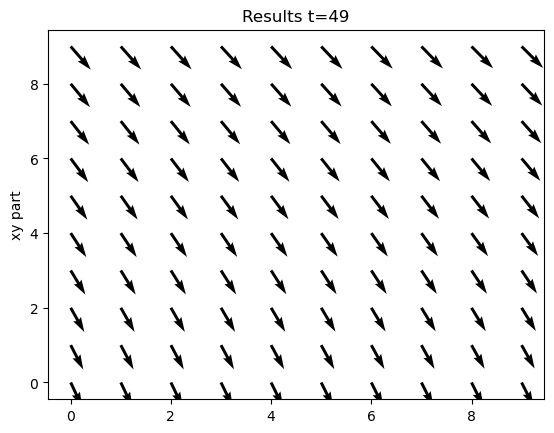

In [ ]:
print(np.min(u_predict[:,:,0].T))
print(np.max(u_predict[:,:,0].T))

fig, ax = plt.subplots(1)

ax.set_ylabel("xy part")
vuv_quiver = ax.quiver(
    np.arange(u_predict.shape[0]),
    np.arange(u_predict.shape[1]),
    u_predict[:,:,0],
    v_predict[:,:,0],
    angles='xy', scale_units='xy', scale=1
)

def animate(t_curr):
    ax.set_title(f"Results t={t_curr}")
    vuv_quiver.set_UVC(u_predict[:,:,t_curr], v_predict[:,:,t_curr])
    return vuv_quiver,

ani_xy = FuncAnimation(fig, animate, frames=len(v_predict[0,0,:]), blit=True)

ani_xy.save("animation_xy.gif", writer="imagemagick", fps=5)

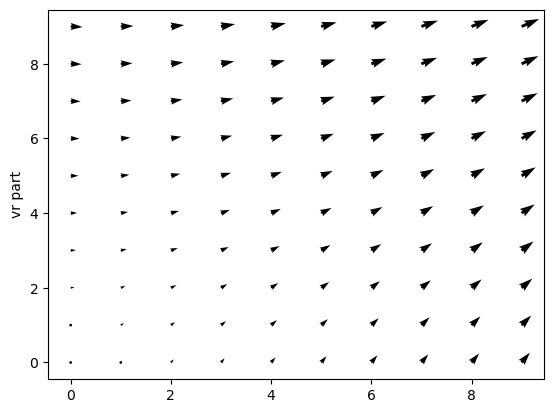

In [ ]:
fig, ax = plt.subplots(1)
frame = 0
ax.set_ylabel("vr part")
vuv_quiver = ax.quiver(
    np.arange(u_predict.shape[0]),
    np.arange(u_predict.shape[1]),
    u_predict[:,:,frame], 
    v_predict[:,:,frame],
    angles='xy', scale_units='xy', scale=1
)

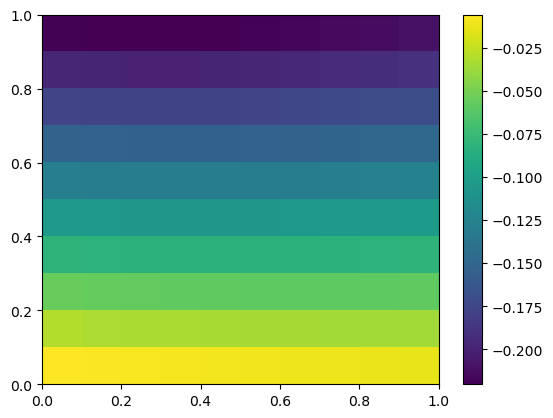

In [ ]:
plt.imshow(
    p_predict[:,:,0],
    interpolation="nearest",
    cmap="viridis",
    extent=[x_min, x_max,y_min, y_max],
    origin="lower",
    aspect="auto"
)
plt.colorbar()

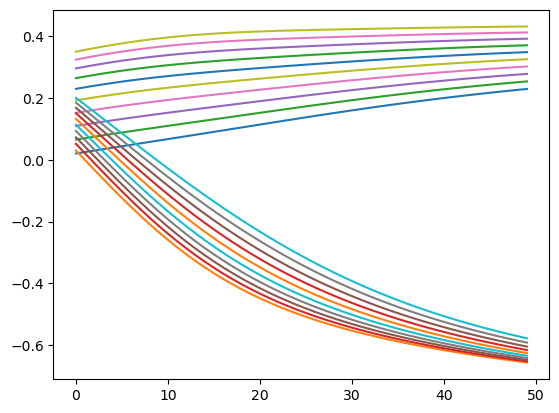

In [ ]:
for i in range(u_predict.shape[0]):
    plt.plot(u_predict[i, i, :])
    plt.plot(v_predict[i, i, :])

f shape: (5000, 5000)


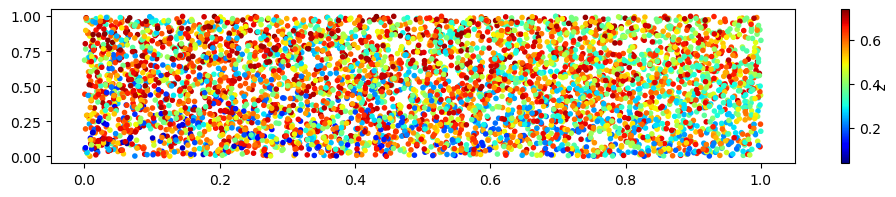

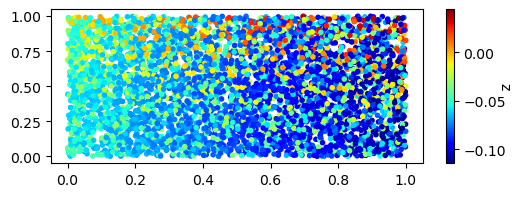

In [ ]:
# early_stopping = EarlyStopping(min_delta=1e-8, patience=40000)
# checker = dde.callbacks.ModelCheckpoint("model/bend_model.ckpt", save_better_only=True, period=1000)
# model.train(iterations=5000, display_every=1000, callbacks=[checker])

# model.compile("L-BFGS")
# losshistory, train_state = model.train(model_save_path = "./model/bend_model.ckpt")

# model.restore("model/bend_model.ckpt-20000.pt", verbose=1)  # Replace ? with the exact filename
X = domain.random_points(5000)
output = model.predict(X)

u_pred = output[:, 0]
v_pred = output[:, 1]
velocity_pred = np.sqrt(u_pred**2 + v_pred**2)
p_pred = output[:, 2]

fig = plt.figure(figsize=(12,2))
plt.scatter(X[:, 0], X[:, 1], c=velocity_pred, cmap='jet', marker = '.')
plt.colorbar().ax.set_ylabel('z', rotation=270)

#residual plot 
f = model.predict(X, operator=navier_stokes)
print("f shape:", f[0].shape)

fig = plt.figure(figsize=(6,2))
sct = plt.scatter(X[:, 0], X[:, 1], c=f[0][:, 0], cmap='jet', marker = '.')
plt.colorbar().ax.set_ylabel('z', rotation=270)
plt.show()

def animate(t_curr):
    sct.set_array(f[0][:, 10 * t_curr])
    return sct, 

ani = FuncAnimation(fig, animate, frames=int(len(f[0][0, :]) / 10), blit=True)
ani.save("animation.gif", writer="imagemagick", fps=10)